# Week 11 In Class Group Work

## Time Series Models

1. Explore Google Trends https://trends.google.com/. Find a topic of interest to you with more than a year of trend data, and export it.
a. Import the data into a pandas dataframe
b. Decide whether ARMA, ARIMA, or SARIMA makes more sense for the dataset
c. Run either an ARMA, ARIMA, or SARIMA on it
d. Explain the results
e. Discuss your findings with your group and explain what trend someone else chose and why they chose the model they did.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import signal

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')


For this exercise, the .csv file contains search interest in the term "data science" in the US for the 5 year period starting on 04/12/2016.

In [2]:
#Read in the trend dataset

df = pd.read_csv('TrendsDS.csv', parse_dates = True, index_col = 'Week')
df.head()

,Data_Science
Week,
2016-12-04,47
2016-12-11,45
2016-12-18,43
2016-12-25,27
2017-01-01,52


In [3]:
#quick check for null values, dtypes, etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2016-12-04 to 2021-11-28
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Data_Science  261 non-null    int64
dtypes: int64(1)
memory usage: 4.1 KB


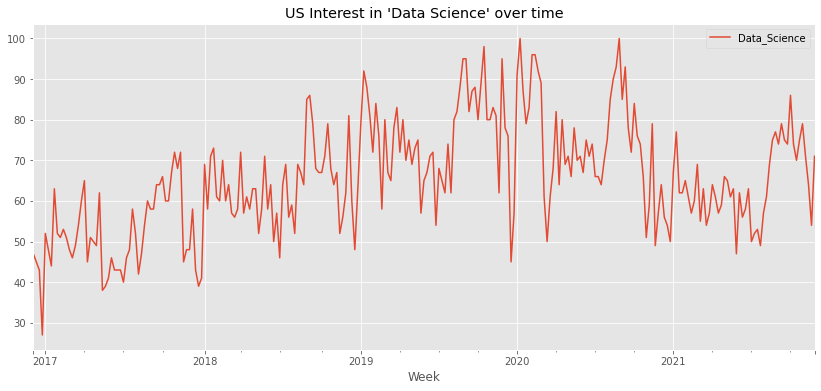

In [4]:
#plotting the data
df.plot(figsize=(14,6))
plt.title ("US Interest in 'Data Science' over time");

To evaluate the stationarity of these data, we can look at some plots. Let's check to see if there's seasonality (method from https://medium.com/analytics-vidhya/time-series-forecasting-sarima-vs-auto-arima-models-f95e76d71d8f):

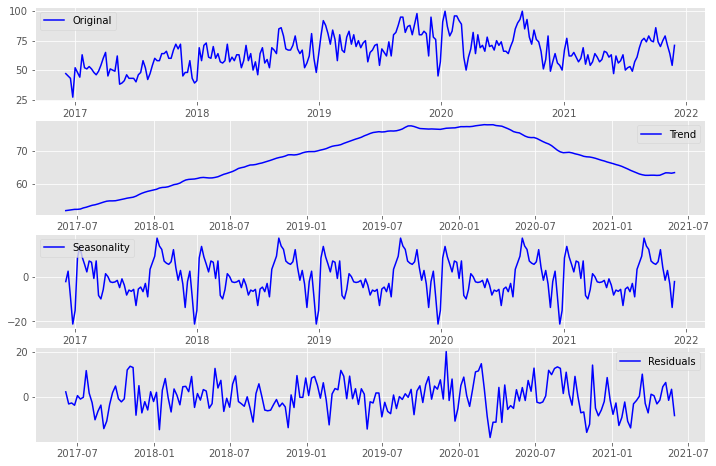

In [5]:
decomposition = seasonal_decompose(df)

#Separate trend, seasonality, and noise

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

#Plot it all together

plt.figure(figsize = (12,8))
plt.subplot(411)
plt.plot(df, label = 'Original', color = 'blue')
plt.legend(loc = 'best')
plt.subplot(412)
plt. plot(trend, label = 'Trend', color = 'blue')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color = 'blue')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals', color = 'blue')
plt. legend(loc = 'best')
plt. tight_layout;

There's a (nonlinear) trend and a signature of seasonality. So, this is nonstationary. Given the signature of seasonality, I should use the SARIMA model.

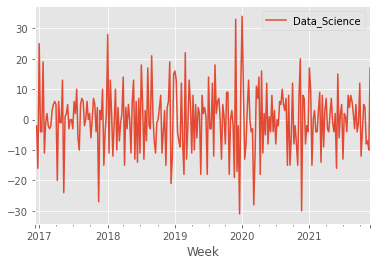

In [6]:
#Making the data stationary by taking the difference (simple)
df_stat = df.diff().dropna()
df_stat.head()
df_stat.plot();

This looks like it's making it stationary. Additional differences didn't improve things (so d = 1)

I wanted to run the SARIMA and followed the info in machinelearningmastery.com. I got confused figuring out the hyperparameters. Instead, I've done the ARIMA, for the sake of completing this exercise. I recogize that the ARIMA and SARIMA share the three trend elements (autoregression, difference, and moving average). The SARIMA has additional parameters for seasonal elements.

In [35]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df['Data_Science'], order=(1,1,2)) #Not sure why I selected the window size of "2"


In [36]:
# fit model to the data
results = model.fit()

In [37]:
#Plot forecasted search popularity for next 10 days
results_df = pd.DataFrame(results.forecast(steps=10)[0])
results_df.head()

,0
0,68.697490
1,68.786371
2,68.872033
3,68.955676
4,69.038050


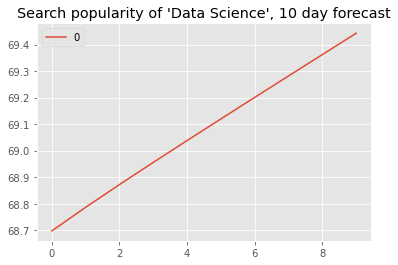

In [38]:
results_df.plot(title = "Search popularity of 'Data Science', 10 day forecast");

In [39]:
#Summary of model performance metrics
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Data_Science   No. Observations:                  260
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -948.113
Method:                       css-mle   S.D. of innovations              9.260
Date:                Fri, 03 Dec 2021   AIC                           1906.226
Time:                        21:42:41   BIC                           1924.029
Sample:                    12-11-2016   HQIC                          1913.383
                         - 11-28-2021                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0802      0.085      0.947      0.344      -0.086       0.246
ar.L1.D.Data_Science     0.6277      0.134      4.680      0.000       0.365       0.891
ma.L1.D.Data_Science    -1.0973      0.165     -6.657      0.000      -1.420      -0.774
ma.L2.D.Data_Science     0.1491      0.143      1.042      0.297      -0.131       0.430
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5930           +0.0000j            1.5930            0.0000
MA.1            1.0656           +0.0000j            1.0656            0.0000
MA.2            6.2925           +0.0000j            6.2925            0.0000
-----------------------------------------------------------------------------
"""

I am not sure what I did wrong here. I originally thought that I was supposed to use the df that I had applied the differencing techique to, but I got angry error messages. I am also having a hard time interpreting the Aikaike and Bayesian info critera here. 

In [42]:
#Here's what happens when I run the ARIMA on the differenced df:

model_1 = ARIMA(df_stat['Data_Science'], order=(1,1,1))


In [43]:
results_1 = model_1.fit()

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

# Fourier Transform

2. What is a Fourier transform? Perform one on y = np.cos(x/2), and both show (with code) and explain the key elements.

The Fourier transform is a math operation that associates a time- (or space-) dependent function with is representation in a frequency domain. It decomposes a signal into its constituent (sine and cosine) functions and indicates their "intensity", in other words, their contribution to the original signal. The frequency displayed is the actual frequency of each consituent function, and the intensity indicates that frequency's relative contribution to the parent function.

The Fast Fourier Transform (FFT) is an algorithm for computing the discrete Fourier transform (DFT). It is widely used in signal processing. 

In the example below, first, we plot the periodic function cosine (x/2). Then, we follow up with a FFT: 

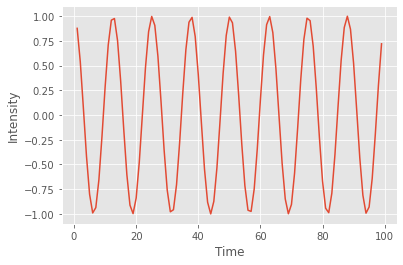

In [44]:
from scipy import signal

x = np.arange(1, 100, 1)
y = np.cos(x/2)
plt.plot(x,y)
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.show()

#Here's the cosine function:

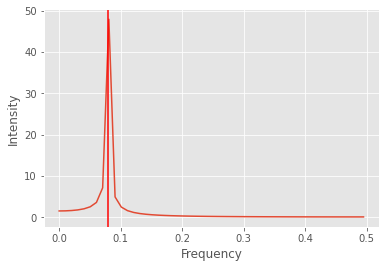

In [45]:
#Power spectral density (PSD):
#This is useful for signals coming from stochastic (i.e. stationary) processes. The power spectrum refers to the spectral energy distribution that wold be found per unit time
#(One way to find the PSD is to estimate it by squaring the magnitue of the DFT.)

psd = np.abs(np.fft.rfft(y))

#The function called returns the DFT sample frequencies (spectral content). It returns a float array, "freq", contining the frequency bin centers in cycles per unit of the sample spacing (from the documentation).
freqs = np.fft.rfftfreq(len(y))

#Now, plot the frequencies against the power spectral density:

plt.plot(freqs,psd)

#amplitude
plt.axvline(1/(4*np.pi), c = 'r')
plt.xlabel('Frequency')
plt.ylabel('Intensity')
plt.show()


So here we see that the input signal is made up of one fuction with a particular frequency of about .08. The intensity is 50 (units?) but I'm not exactly sure what that means, especially as there are no other frequencies present in this display. It's hard to talk about decomposition of a signal into component frequencies when the input is a pure periodic function. I'm going to see if I can superpose the class example with this one and then re-run everything.

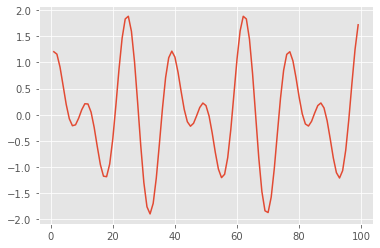

In [46]:
#Making a more complicated signal:

z = np.sin(x/3) + np.cos(x/2)

plt.plot(x,z)

Okay, this is a more complicated signal with a lot of peaks and troughs. It's a little more challenging to discern the component functions by inspection. Let's try the FFT now.

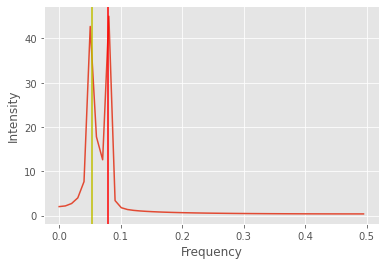

In [47]:
#Power spectral density of z:
psd_z = np.abs(np.fft.rfft(z))

#Frequencies of z:
freqs_z = np.fft.rfftfreq(len(z))

#Plotting:

plt.plot(freqs_z,psd_z)

#amplitude
plt.axvline(1/(4*np.pi), c = 'r')
plt.axvline(1/(6*np.pi), c = 'y')
plt.xlabel('Frequency')
plt.ylabel('Intensity')
plt.show()

Voila! We have successfully decomposed the original signal into its two fundamental functions, sin(x/3) and cos(x/2). Because the intensities are so similar, we could say that both functions contribute roughly equal proportions to the parent signal.